In [46]:
include("../code/headers.jl")
include("../code/bp.jl")
using ProgressMeter

## Check seaweed code

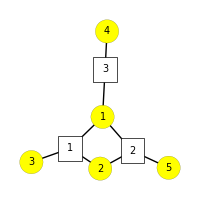

In [2]:
H = [1 1 1 0 0 ; 1 1 0 0 1; 1 0 0 1 0]
fg = FactorGraphGF2(H)
depths,_,_ = lr(fg)   # leaf removal
plot(fg, size=(200,200), randseed=1)

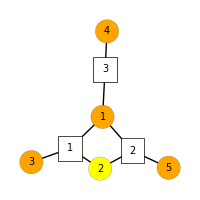

In [3]:
seed = 1
sw = seaweed(fg, seed, depths)
plot(fg, size=(200,200), randseed=1, highlighted_nodes=findall(Bool.(sw)))

# Experiments with Montecarlo

In [4]:
function mc(fg::FactorGraph, N::Int, H::Number, src)
    D = sum(src)
    x = zeros(Int, fg.n, N)
    d = zeros(N); d[1] = sum(xor.(x[:,1],src))/fg.n
    # leaf removal
    depths = lr(fg)[1]
    isincore = (depths .== 0)
    not_in_core = findall(.!isincore)
    xnew = zeros(Int,fg.n)
    @showprogress for i in 2:N
        # flip seaweed
        sw = seaweed(fg, rand(not_in_core), depths, isincore)
        # accept/reject
        xnew .= xor.(sw,x[:,i-1])
        Dnew = sum(xor.(xnew,src))
        accept = false
        if Dnew < D
            accept = true
        elseif rand() < exp(-2H*(Dnew-D))
            accept = true
        end
        # update
        if accept
            x[:,i] = xnew
            D = Dnew
        else
            x[:,i] = x[:,i-1]
        end
        d[i] = D/fg.n
    end
    x, d
end

mc (generic function with 1 method)

In [39]:
m = 66*100
R = 0.8/3
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = [0,1-r,r]
K = [0,0,1]
nedges = 3m
lambda,rho = nodes2edges(Λ,K)
b = round(Int, sqrt(n)*4)
fg1 = ldpc_graphGF2(n,m,nedges,lambda,rho, accept_multiedges=false)
fg = FactorGraphGF2(fg1.H[1:end-b,:])

Factor Graph with n=8979 variables and m=6221 factors defined on GF(2)


Get an idea of the minimal distortion at our rate

R = 0.26666666666666666


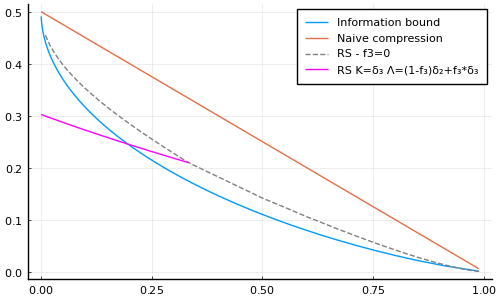

In [52]:
pl = plot_rdb()
@show R
plot(pl, size=(500,300))

In [40]:
N = 10^6
H = 2
dist = 0.2
src = [rand()<dist for _ in 1:fg.n];

In [41]:
x,d = mc(fg, N, H, src);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:46


Compute "marginals", i.e. for each variable $i$, the proportion of configurations in which it took value $1$. Then plot a histogram

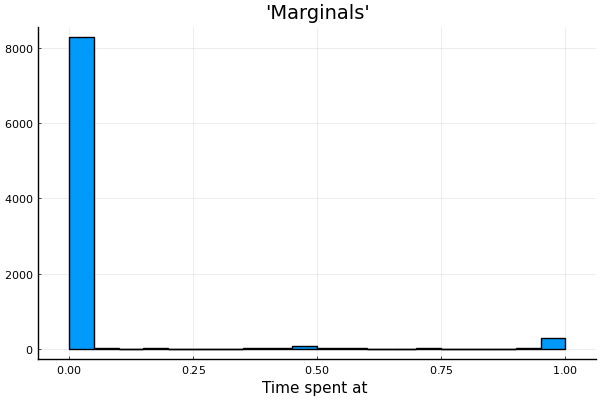

In [42]:
marg = mean(x, dims=2)
h1 = histogram(marg, bins=25, label="") 
title!("'Marginals'"); xlabel!("Time spent at ")
h1

Plot the hamming weight of configurations throughout the iterations. (One needs to downsample otherwise the plot becomes super slow or it turns out blank)

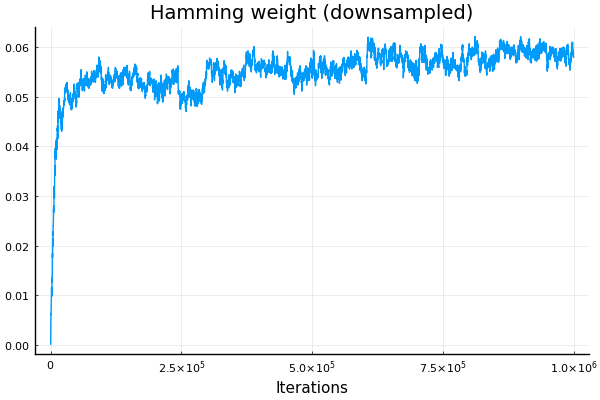

In [43]:
hamm = vec(sum(x, dims=1))/fg.n;
ds = 10
p1 = plot(1:ds:length(hamm), hamm[1:ds:end], label="")
xlabel!("Iterations")
title!("Hamming weight (downsampled)")
p1

Plot the distortion throughout the iterations

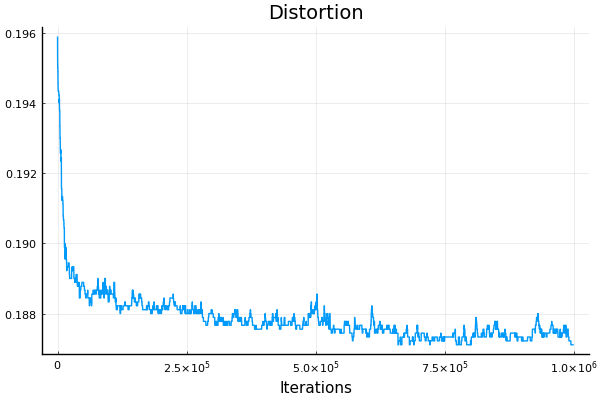

In [44]:
plot(d, label=""); title!("Distortion"); xlabel!("Iterations")

In [11]:
# u = unique(x, dims=2);

In [12]:
# marg_u = mean(u, dims=2)
# h2 = histogram(marg_u, bins=25)
# title!("'Marginals' - Unique configurations")
# plot(h1,h2,layout=2, size=(1000,400))

In [13]:
# hamm_u = sum(u, dims=1)
# p2 = plot(hamm_u[1:1:end])
# title!("Hamming weight - Unique configurations")
# xlabel!("Iterations")
# plot(p1,p2,layout=2, size=(1000,400))

## Observe size of seaweeds as n grows

Question: what is the right scaling for the number of factors to remove? Probably something sublinear (?)

TODO: non-recursive seaweed

In [31]:
mm = 66 * 2 .^(4:8)
meansizes = fill(NaN,length(mm))
sdsizes = zeros(length(mm))
navg = 10
nseaweeds = 500

R = 0.8/3
r = 1 - 3R
Λ = [0,1-r,r]
K = [0,0,1]
lambda,rho = nodes2edges(Λ,K)
for (i,m) in enumerate(mm)  
    nedges = 3m
    n = round(Int, 3m/(2+r))
    # b is the number of removed factors
#     @show b = round(Int,sqrt(n)*4)
    @show b = round(Int,n/20)
    fg1 = ldpc_graphGF2(n,m,nedges,lambda,rho, accept_multiedges=false)
    fg = FactorGraphGF2(fg1.H[1:end-b,:])
    depths = lr(fg)[1]
    isincore = (depths .== 0)
    not_in_core = findall(.!isincore)
    sw_size = zeros(n)
    @showprogress for s in 1:n
        sw = seaweed(fg, rand(not_in_core), depths, isincore)
        sw_size[s] = sum(sw)
    end
    meansizes[i] = mean(sw_size)
    sdsizes[i] = std(sw_size)/sqrt(n)
    println("m=$m finished. $i of ", length(mm))
end
        

b = round(Int, n / 20) = 4
m=66 finished. 1 of 9
b = round(Int, n / 20) = 9
m=132 finished. 2 of 9
b = round(Int, n / 20) = 18
m=264 finished. 3 of 9
b = round(Int, n / 20) = 36
m=528 finished. 4 of 9
b = round(Int, n / 20) = 72


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


m=1056 finished. 5 of 9
b = round(Int, n / 20) = 144


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


m=2112 finished. 6 of 9
b = round(Int, n / 20) = 288


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


m=4224 finished. 7 of 9
b = round(Int, n / 20) = 576


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


m=8448 finished. 8 of 9
b = round(Int, n / 20) = 1152


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


m=16896 finished. 9 of 9


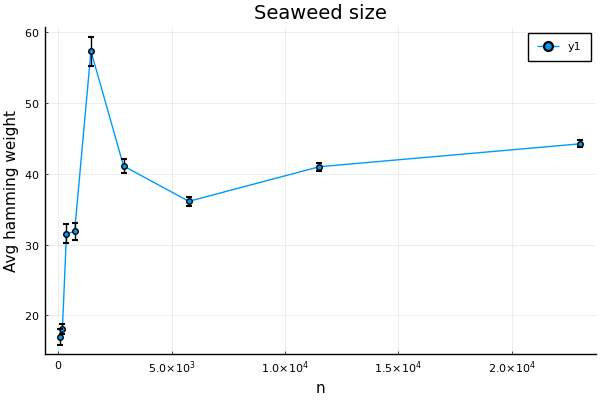

In [37]:
nn = [round(Int, 3m/(2+r)) for m in mm]
plot(nn, meansizes, marker=:circle, yerr=sdsizes)
xlabel!("n"); ylabel!("Avg hamming weight")
title!("Seaweed size")